

# Defining libraries and processing data from the dataset

In [ ]:

#importing the required libraries
import numpy as np
import tensorflow as tf
print(tf.config.list_physical_devices())
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
!pip install pydicom
import pydicom as py
from pydicom.pixel_data_handlers.util import apply_voi_lut
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import torch.utils.data as data
from PIL import Image, ImageFilter
import cv2
import os
import pandas as pd
from torchvision import transforms

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [ ]:
!nvidia-smi

Thu Dec 29 15:20:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    50W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA A100-SXM4-40GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.8/dist-packages/torch/cuda/memory.py:395: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


Data preprocessing

Getting all files in path


In [ ]:
import os
#mount drive
from google.colab import drive
drive.mount('/content/drive')
# def get_list_from_filenames(file_path):
#     # input:    relative path to .txt file with file names
#     # output:   list of relative path names
#     with open(file_path) as f:
#         lines = f.read().splitlines()
#     return lines

def getdir(path):
    dirlist = []
    for file in os.listdir(path):
        # if os.path.isdir(os.path.join(path, file)):
        dirlist.append(file)
    return dirlist


#path = "/content/drive/MyDrive/research_data/stage1/"
#list = getdir(path)
#print(list[123])


Mounted at /content/drive


grabbing amplification matrix


In [ ]:
from PIL import Image, ImageOps
from numpy import asarray

def getamp(path):
  file_paths = '/content/drive/MyDrive/labeled /'
  filename_list = getdir(path)
  arr = []
  minx = 1000
  miny = 1000
  for i in range(len(filename_list)):
    file_path = path + filename_list[i]
    img = Image.open(file_path)
    im2 = ImageOps.grayscale(img)
    numpydata = asarray(im2)
    miny = min(miny,len(numpydata))
    minx = min(minx, len(numpydata[0]))
    arr.append(numpydata)


  w, h = 512, 512
  Matrix = [[0 for x in range(w)] for y in range(h)]
  for i in range(miny):
    for j in range(minx):
      for z in range(len(filename_list)):
        Matrix[i][j] += arr[z][i][j]
  for i in range(miny):
    for j in range(minx):
      for z in range(len(filename_list)):
        Matrix[i][j] = Matrix[i][j]/len(filename_list)
  return Matrix

one hot encoding for even spread


In [ ]:
def one_hot(classname):
    Label = ['adenocarcinoma', 'large cell', 'NA', 'nos', 'squamous cell carcinoma']
    Label = np.array(Label)
    Label = Label.reshape(-1, 1)
   # Label = list(Label)

    le = preprocessing.OneHotEncoder()
    encoder = le.fit(Label)
    # classname = encoder.transform([[classname]]).toarray
    adenocarcinoma = encoder.transform([['adenocarcinoma']]).toarray()
    large_cell = encoder.transform([['large cell']]).toarray()
    NA = encoder.transform([['NA']]).toarray()
    nos = encoder.transform([['nos']]).toarray()
    squamous_cell_carcinoma = encoder.transform([['squamous cell carcinoma']]).toarray()
    label_code = {}
    label_code['adenocarcinoma'] = adenocarcinoma
    label_code['large cell'] = large_cell
    label_code['NA'] = NA
    label_code['nos'] = nos
    label_code['squamous cell carcinoma'] = squamous_cell_carcinoma
    return label_code[classname]
#adenocarcinoma = one_hot('adenocarcinoma')
#na = one_hot('NA')
#print(adenocarcinoma)
#print(na)
def one_hot_stages(classname):
    label = ['Stage Ⅰ', 'Stage Ⅱ', 'Stage ⅢA', 'Stage ⅢB']
    label = np.array(label)
    label = label.reshape(-1, 1)
    label = list(label)

    le = preprocessing.OneHotEncoder()
    encoder = le.fit(label)
    stageI = encoder.transform([['Stage Ⅰ']]).toarray()
    stageII = encoder.transform([['Stage Ⅱ']]).toarray()
    stageIIIA = encoder.transform([['Stage ⅢA']]).toarray()
    stageIIIB = encoder.transform([['Stage ⅢB']]).toarray()
    label_code = {}
    label_code['Stage Ⅰ'] = stageI
    label_code['Stage Ⅱ'] = stageII
    label_code['Stage ⅢA']  = stageIIIA
    label_code['Stage ⅢB'] = stageIIIB
    return label_code[classname]

# stage1 = one_hot_stages('Stage Ⅰ')
# stage2 = one_hot_stages('Stage Ⅱ')
# stage3 = one_hot_stages('Stage ⅢA')
# stage4 = one_hot_stages('Stage ⅢB')
#

stage 1

In [ ]:


# gpu = 0

# def get_list_from_filenames(file_path):
# 	with open(file_path) as f:
# 		lines = f.read().splitlines()

	# return lines

class stage1_data(data.Dataset):

    def __init__(self, indexes, labels):
        self.indexes = indexes
        self.labels = labels


    def __getitem__(self, index):
        num = self.indexes[index]
        # X = torch.as_tensor(num)
        X = np.float32(num)
        # X = torch.Tensor()
        Y = self.labels[index]
        return X,Y




    def __len__(self):
        return len(self.indexes)  #returns length


# print(train_loader)
    def loaddata():
        cts = []
        labels = []
        file_paths = '/content/drive/MyDrive/data/Stage1/squamous cell carcinoma/' #change this once found
        filename_list = getdir(file_paths)
        print("scc")
        for i in range(2000):
            file_path = file_paths + filename_list[i]
            if 'dcm' in filename_list[i]:
                img = py.dcmread(file_path)
                img = np.float32(img.pixel_array)
                #print('reading dcm')
            else:
                img = np.load(file_path)
                img = img['arr_0']
              #  print('reading npz')
            img = img + Matrix
            cts.append(img)
            labels.append(0)
            #scc = one_hot('squamous cell carcinoma')
            #scc = np.float32(scc)
            #labels.append(scc)
        file_paths = '/content/drive/MyDrive/data/Stage1/large cell/'
        filename_list = getdir(file_paths)
        print("large cell")
        for i in range(2000):
            file_path = file_paths + filename_list[i]
            if 'dcm' in filename_list[i]:
                img = py.dcmread(file_path)
                img = np.float32 (img.pixel_array)
                #print('reading dcm')
            else:
                img = np.load(file_path)
                img = img['arr_0']
                #print('reading npz')
            cts.append(img)
            labels.append(1)
            #largecell = one_hot("large cell")
           # largecell = np.float32(largecell)
           # labels.append(largecell)
        file_paths = '/content/drive/MyDrive/data/Stage1/NA/'
        filename_list = getdir(file_paths)
        print("NA")
        for i in range(2000):
            file_path = file_paths + filename_list[i]
            if 'dcm' in filename_list[i]:
                img = py.dcmread(file_path)
                img = np.float32 (img.pixel_array)
                #print('reading dcm')
            else:
                img = np.load(file_path)
                img = img['arr_0']
                #print('reading npz')
            cts.append(img)
            labels.append(2)
            #NA = one_hot("NA")
            #NA = np.float32(NA)
            #labels.append(NA)
        file_paths = '/content/drive/MyDrive/data/Stage1/nos/'
        filename_list = getdir(file_paths)
        print("Nos")
        for i in range(2000):
            file_path = file_paths + filename_list[i]
            if 'dcm' in filename_list[i]:
                img = py.dcmread(file_path)
                img = np.float32 (img.pixel_array)
                #print('reading dcm')
            else:
                img = np.load(file_path)
                img = img['arr_0']
                #print('reading npz')
            cts.append(img)
            labels.append(3)
            #nos = one_hot("nos")
            #nos = np.float32(nos)
            #labels.append(nos)
        file_paths = '/content/drive/MyDrive/data/Stage1/adenocarcinoma/'
        filename_list = getdir(file_paths)
        print("adenocarcinoma")
        for i in range(2000):
            file_path = file_paths + filename_list[i]
            if 'dcm' in filename_list[i]:
                img = py.dcmread(file_path)
                img = np.float32 (img.pixel_array)
                #print('reading dcm')
            else:
                img = np.load(file_path)
                img = img['arr_0']
                #print('reading npz')
            cts.append(img)
            labels.append(4)
            #adenocarcinoma = one_hot('adenocarcinoma')
            #adenocarcinoma = np.float32(adenocarcinoma)
            #labels.append(adenocarcinoma)
        return cts, labels

cts, labels = stage1_data.loaddata()
img = cts[10]
plt.figure(figsize = (20,20))
plt.imshow(img, 'gray')
patient_train, patient_test, label_train, label_test = train_test_split(cts, labels, test_size = 0.4, random_state = 42)
#train_dataset1 = stage1_data(ct_train1, label_train1)
#test_dataset1 = stage1_data(ct_test1, label_test1)




Stage 2


Streaming output truncated to the last 5000 lines.
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
reading npz
r

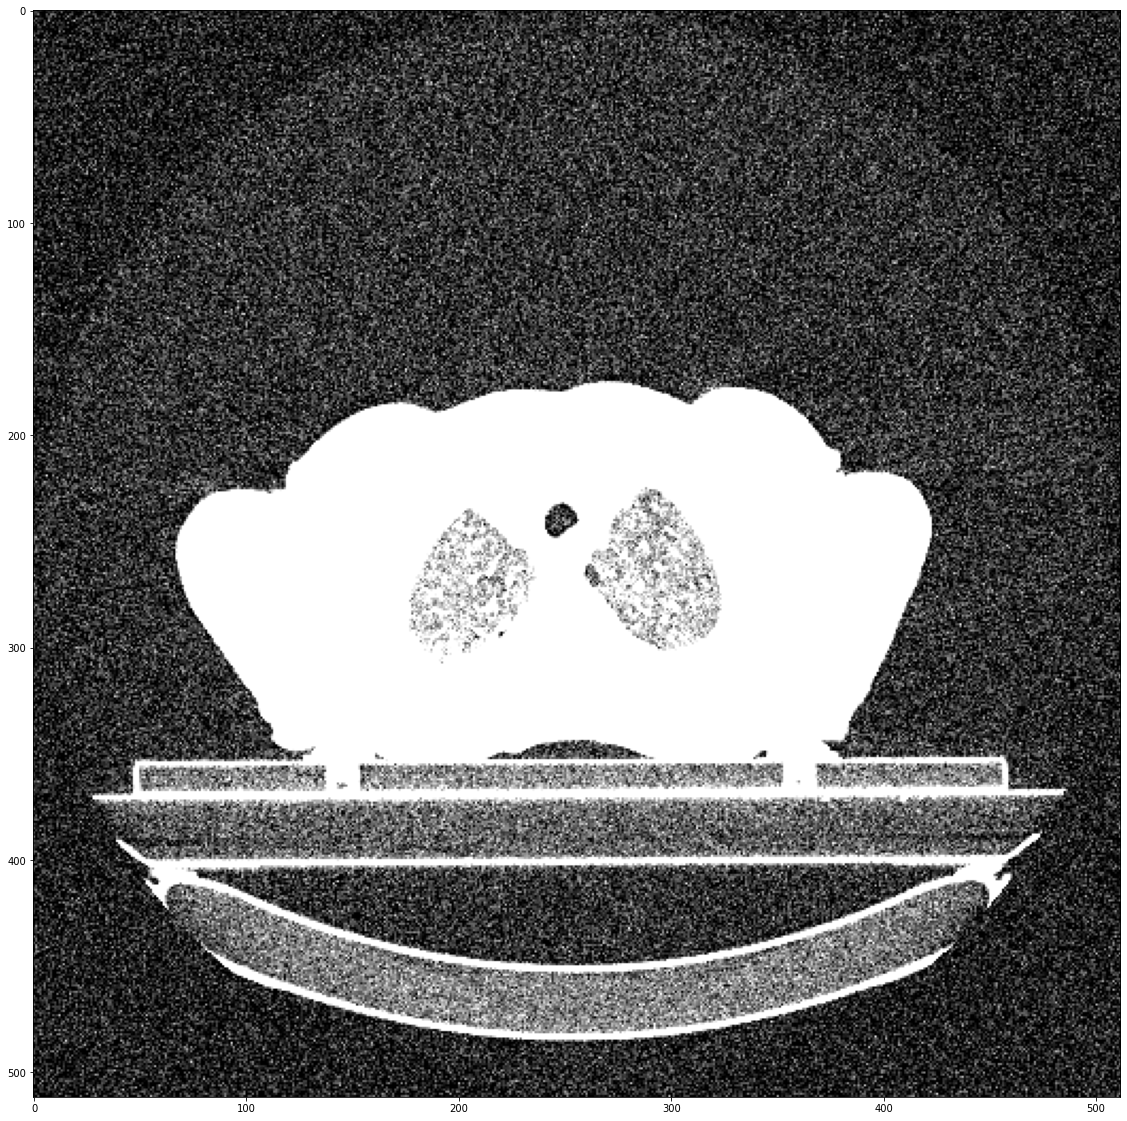

In [ ]:
class stage2_data(data.Dataset):

    def __init__(self, indexes, labels):
        self.indexes = indexes
        self.labels = labels


    def __getitem__(self, index):
        num = self.indexes[index]
        # X = torch.as_tensor(num)
        X = np.float32(num)
        # X = torch.Tensor()
        Y = self.labels[index]
        return X,Y




    def __len__(self):
        return len(self.indexes)  #returns length


# print(train_loader)
    def loaddata():
        cts = []
        labels = []
        file_paths = '/content/drive/MyDrive/data/Stage2/squamous cell carcinoma/' #change this once found
        filename_list = getdir(file_paths)
        file_path = '/content/drive/MyDrive/image/B/a/J/'
        amp = getamp(file_path)
        print("scc")
        for i in range(len(filename_list)-1500):
            file_path = file_paths + filename_list[i]
            if 'dcm' in filename_list[i]:
                img = py.dcmread(file_path)
                img = np.float32(img.pixel_array)
                #print('reading dcm')
            else:
                img = np.load(file_path)
                img = img['arr_0']
                print('reading npz')
            img = img + amp
            cts.append(img)
            labels.append(0)
            #scc = one_hot('squamous cell carcinoma')
            #scc = np.float32(scc)
            #labels.append(scc)
        file_paths = '/content/drive/MyDrive/data/Stage2/large cell/'
        filename_list = getdir(file_paths)
        print("large cell")
        for i in range(len(filename_list)-1000):
            file_path = file_paths + filename_list[i]
            if 'dcm' in filename_list[i]:
                img = py.dcmread(file_path)
                img = np.float32 (img.pixel_array)
                #print('reading dcm')
            else:
                img = np.load(file_path)
                img = img['arr_0']
                #print('reading npz')
            cts.append(img)
            labels.append(1)
            #largecell = one_hot("large cell")
           # largecell = np.float32(largecell)
           # labels.append(largecell)
        file_paths = '/content/drive/MyDrive/data/Stage2/NA/'
        filename_list = getdir(file_paths)
        print("NA")
        for i in range(len(filename_list)):
            file_path = file_paths + filename_list[i]
            if 'dcm' in filename_list[i]:
                img = py.dcmread(file_path)
                img = np.float32 (img.pixel_array)
                #print('reading dcm')
            else:
                img = np.load(file_path)
                img = img['arr_0']
                #print('reading npz')
            cts.append(img)
            labels.append(2)
            #NA = one_hot("NA")
            #NA = np.float32(NA)
            #labels.append(NA)
        file_paths = '/content/drive/MyDrive/data/Stage2/nos/'
        filename_list = getdir(file_paths)
        print("Nos")
        for i in range(len(filename_list)-500):
            file_path = file_paths + filename_list[i]
            if 'dcm' in filename_list[i]:
                img = py.dcmread(file_path)
                img = np.float32 (img.pixel_array)
                #print('reading dcm')
            else:
                img = np.load(file_path)
                img = img['arr_0']
                #print('reading npz')
            cts.append(img)
            labels.append(3)
            #nos = one_hot("nos")
            #nos = np.float32(nos)
            #labels.append(nos)
        file_paths = '/content/drive/MyDrive/data/Stage2/adenocarcinoma/'
        filename_list = getdir(file_paths)
        print("adenocarcinoma")
        file_path = '/content/drive/MyDrive/image/B/b/J/'
        amp = getamp(file_path)
        for i in range(len(filename_list)):
            file_path = file_paths + filename_list[i]
            if 'dcm' in filename_list[i]:
                img = py.dcmread(file_path)
                img = np.float32 (img.pixel_array)
                #print('reading dcm')
            else:
                img = np.load(file_path)
                img = img['arr_0']
                #print('reading npz')
            cts.append(img)
            labels.append(4)
            #adenocarcinoma = one_hot('adenocarcinoma')
            #adenocarcinoma = np.float32(adenocarcinoma)
            #labels.append(adenocarcinoma)
        return cts, labels

cts, labels = stage2_data.loaddata()
patient_train, patient_test, label_train, label_test = train_test_split(cts, labels, test_size = 0.4, random_state = 42)
img = cts[10]
plt.figure(figsize = (20,20))
plt.imshow(img, 'gray')

Stage3a

In [ ]:
class stage3a_data(data.Dataset):

    def __init__(self, indexes, labels):
        self.indexes = indexes
        self.labels = labels


    def __getitem__(self, index):
        num = self.indexes[index]
        # X = torch.as_tensor(num)
        X = np.float32(num)
        # X = torch.Tensor()
        Y = self.labels[index]
        return X,Y




    def __len__(self):
        return len(self.indexes)  #returns length


# print(train_loader)
    def loaddata():
        cts = []
        labels = []
        file_paths = '/content/drive/MyDrive/data/Stage3A/squamous cell carcinoma/' #change this once found
        filename_list = getdir(file_paths)
        print("scc")
        for i in range(len(filename_list)-2000):
            file_path = file_paths + filename_list[i]
            if 'dcm' in filename_list[i]:
                img = py.dcmread(file_path)
                img = np.float32(img.pixel_array)
                #print('reading dcm')
            else:
                img = np.load(file_path)
                img = img['arr_0']
                #print('reading npz')
            cts.append(img)
            labels.append(0)
            #scc = one_hot('squamous cell carcinoma')
            #scc = np.float32(scc)
            #labels.append(scc)
        file_paths = '/content/drive/MyDrive/data/Stage3A/large cell/'
        filename_list = getdir(file_paths)
        print("large cell")
        for i in range(len(filename_list)-2000
                       ):
            file_path = file_paths + filename_list[i]
            if 'dcm' in filename_list[i]:
                img = py.dcmread(file_path)
                img = np.float32 (img.pixel_array)
                #print('reading dcm')
            else:
                img = np.load(file_path)
                img = img['arr_0']
                #print('reading npz')
            cts.append(img)
            labels.append(1)
            #largecell = one_hot("large cell")
           # largecell = np.float32(largecell)
           # labels.append(largecell)
        file_paths = '/content/drive/MyDrive/data/Stage3A/NA/'
        filename_list = getdir(file_paths)
        print("NA")
        for i in range(len(filename_list)):
            file_path = file_paths + filename_list[i]
            if 'dcm' in filename_list[i]:
                img = py.dcmread(file_path)
                img = np.float32 (img.pixel_array)
                #print('reading dcm')
            else:
                img = np.load(file_path)
                img = img['arr_0']
                #print('reading npz')
            cts.append(img)
            labels.append(2)
            #NA = one_hot("NA")
            #NA = np.float32(NA)
            #labels.append(NA)
        file_paths = '/content/drive/MyDrive/data/Stage3A/nos/'
        filename_list = getdir(file_paths)
        print("Nos")
        for i in range(len(filename_list)-2000):
            file_path = file_paths + filename_list[i]
            if 'dcm' in filename_list[i]:
                img = py.dcmread(file_path)
                img = np.float32 (img.pixel_array)
                #print('reading dcm')
            else:
                img = np.load(file_path)
                img = img['arr_0']
                #print('reading npz')
            cts.append(img)
            labels.append(3)
            #nos = one_hot("nos")
            #nos = np.float32(nos)
            #labels.append(nos)
        file_paths = '/content/drive/MyDrive/data/Stage3A/adenocarcinoma/'
        filename_list = getdir(file_paths)
        print("adenocarcinoma")
        for i in range(len(filename_list)):
            file_path = file_paths + filename_list[i]
            if 'dcm' in filename_list[i]:
                img = py.dcmread(file_path)
                img = np.float32 (img.pixel_array)
                #print('reading dcm')
            else:
                img = np.load(file_path)
                img = img['arr_0']
                #print('reading npz')
            cts.append(img)
            labels.append(4)
            #adenocarcinoma = one_hot('adenocarcinoma')
            #adenocarcinoma = np.float32(adenocarcinoma)
            #labels.append(adenocarcinoma)
        return cts, labels

cts, labels = stage3a_data.loaddata()
patient_train, patient_test, label_train, label_test = train_test_split(cts, labels, test_size = 0.4, random_state = 42)

scc
large cell


Stage3b

In [ ]:
class stage3b_data(data.Dataset):

    def __init__(self, indexes, labels):
        self.indexes = indexes
        self.labels = labels


    def __getitem__(self, index):
        num = self.indexes[index]
        # X = torch.as_tensor(num)
        X = np.float32(num)
        # X = torch.Tensor()
        Y = self.labels[index]
        return X,Y




    def __len__(self):
        return len(self.indexes)  #returns length


# print(train_loader)
    def loaddata():
        cts = []
        labels = []
        file_paths = '/content/drive/MyDrive/data/Stage3B/squamous cell carcinoma/' #change this once found
        filename_list = getdir(file_paths)
        print("scc")
        for i in range(len(filename_list)):
            file_path = file_paths + filename_list[i]
            if 'dcm' in filename_list[i]:
                img = py.dcmread(file_path)
                img = np.float32(img.pixel_array)
                #print('reading dcm')
            else:
                img = np.load(file_path)
                img = img['arr_0']
                #print('reading npz')
            cts.append(img)
            labels.append(0)
            #scc = one_hot('squamous cell carcinoma')
            #scc = np.float32(scc)
            #labels.append(scc)
        file_paths = '/content/drive/MyDrive/data/Stage3B/large cell/' #change this once found
        filename_list = getdir(file_paths)
        print("scc")
        for i in range(len(filename_list)):
            file_path = file_paths + filename_list[i]
            if 'dcm' in filename_list[i]:
                img = py.dcmread(file_path)
                img = np.float32(img.pixel_array)
                #print('reading dcm')
            else:
                img = np.load(file_path)
                img = img['arr_0']
                #print('reading npz')
            cts.append(img)
            labels.append(0)
            #scc = one_hot('squamous cell carcinoma')
            #scc = np.float32(scc)
            #labels.append(scc)
        file_paths = '/content/drive/MyDrive/data/Stage3B/NA/'
        filename_list = getdir(file_paths)
        print("NA")
        for i in range(len(filename_list)):
            file_path = file_paths + filename_list[i]
            if 'dcm' in filename_list[i]:
                img = py.dcmread(file_path)
                img = np.float32 (img.pixel_array)
                #print('reading dcm')
            else:
                img = np.load(file_path)
                img = img['arr_0']
                #print('reading npz')
            cts.append(img)
            labels.append(2)
            #NA = one_hot("NA")
            #NA = np.float32(NA)
            #labels.append(NA)
        file_paths = '/content/drive/MyDrive/data/Stage3B/nos/'
        filename_list = getdir(file_paths)
        print("Nos")
        for i in range(len(filename_list)):
            file_path = file_paths + filename_list[i]
            if 'dcm' in filename_list[i]:
                img = py.dcmread(file_path)
                img = np.float32 (img.pixel_array)
                #print('reading dcm')
            else:
                img = np.load(file_path)
                img = img['arr_0']
                #print('reading npz')
            cts.append(img)
            labels.append(3)
            #nos = one_hot("nos")
            #nos = np.float32(nos)
            #labels.append(nos)
        file_paths = '/content/drive/MyDrive/data/Stage3B/adenocarcinoma/'
        filename_list = getdir(file_paths)
        print("adenocarcinoma")
        for i in range(len(filename_list)):
            file_path = file_paths + filename_list[i]
            if 'dcm' in filename_list[i]:
                img = py.dcmread(file_path)
                img = np.float32 (img.pixel_array)
                #print('reading dcm')
            else:
                img = np.load(file_path)
                img = img['arr_0']
                #print('reading npz')
            cts.append(img)
            labels.append(4)
            #adenocarcinoma = one_hot('adenocarcinoma')
            #adenocarcinoma = np.float32(adenocarcinoma)
            #labels.append(adenocarcinoma)
        return cts, labels

cts, labels = stage3b_data.loaddata()
patient_train, patient_test, label_train, label_test = train_test_split(cts, labels, test_size = 0.4, random_state = 42)


scc
scc
NA
Nos
adenocarcinoma


In [ ]:
patient_train = np.array(patient_train)
patient_test = np.array(patient_test)
label_train = np.array(label_train)
label_test = np.array(label_test)
tf.config.list_physical_devices("GPU")


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

data shape for model fitting

In [ ]:
#loading data

#(X_train,y_train) , (X_test,y_test)=mnist.load_data()
#reshaping data
#X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
#X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],X_test.shape[2],1))
#checking the shape after reshaping
print(np.shape(patient_train))
print(np.shape(patient_test))
#normalizing the pixel values
#X_train=X_train/255
#X_test=X_test/255

(9555, 512, 512)
(6370, 512, 512)


# CNN Models

Tensorflow Models

Personal CNN model

In [ ]:
!pip install visualkeras
import visualkeras

#defining model
model=Sequential()
#adding convolution layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(512,512,1)))
#adding pooling layer
model.add(MaxPool2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(512,512,1)))
#adding pooling layer
model.add(MaxPool2D(2,2))
#adding fully connected layer
model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.2))
#adding output layer
model.add(Dense(5,activation='softmax'))
#compiling the model
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
#fitting the model
model.save("mymodel1.h5")
#history = model.fit(patient_train, label_train,epochs=20)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Model evaluation


206/206 [==============================] - 5s 19ms/step - loss: 0.0449 - accuracy: 0.9791
dict_keys(['loss', 'accuracy'])


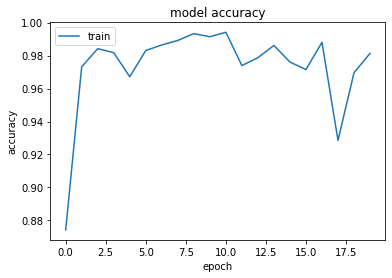

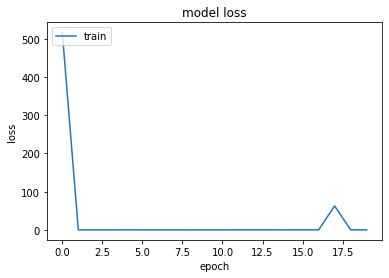

In [ ]:
#evaluting the model

model.evaluate(patient_test,label_test)
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Alexnet

In [ ]:
patient_train = patient_train.reshape(9855,512,512,1)
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(512,512,1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.optimizers.SGD(lr=0.001),metrics=['accuracy'])
#fitting the model
history = model.fit(patient_train,label_train,epochs=20)

Epoch 1/20
308/308 [==============================] - 25s 39ms/step - loss: 1.2553 - accuracy: 0.6412
Epoch 2/20
308/308 [==============================] - 11s 37ms/step - loss: 0.1979 - accuracy: 0.9255
Epoch 3/20
308/308 [==============================] - 11s 37ms/step - loss: 0.0223 - accuracy: 0.9937
Epoch 4/20
308/308 [==============================] - 11s 37ms/step - loss: 0.0090 - accuracy: 0.9979
Epoch 5/20
308/308 [==============================] - 11s 37ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 6/20
308/308 [==============================] - 11s 37ms/step - loss: 0.0014 - accuracy: 0.9999
Epoch 7/20
308/308 [==============================] - 11s 37ms/step - loss: 0.0018 - accuracy: 0.9997
Epoch 8/20
308/308 [==============================] - 11s 37ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 9/20
308/308 [==============================] - 11s 37ms/step - loss: 6.7360e-04 - accuracy: 1.0000
Epoch 10/20
308/308 [==============================] - 11s 37ms/step - loss: 4

206/206 [==============================] - 5s 18ms/step - loss: 4.3598e-05 - accuracy: 1.0000
dict_keys(['loss', 'accuracy'])


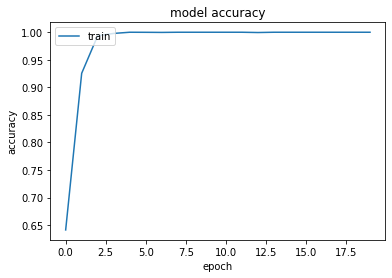

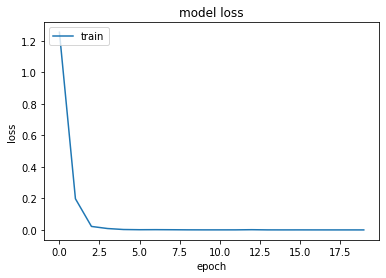

In [ ]:
model.evaluate(patient_test,label_test)
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

VGG 19

In [ ]:
patient_train = patient_train.reshape((9555, 512, 512,1))
model=Sequential()
#adding convolution layer 1
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(512,512,1)))
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(512,512,1)))
model.add(MaxPool2D(2,2))
#adding layer 2
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
#adding layer 3
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
#adding layer 4
model.add(Conv2D(512,(3,3),activation='relu'))
model.add(Conv2D(512,(3,3),activation='relu'))
model.add(Conv2D(512,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
#adding layer 5
model.add(Conv2D(512,(3,3),activation='relu'))
model.add(Conv2D(512,(3,3),activation='relu'))
model.add(Conv2D(512,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dense(2048,activation='relu'))
model.add(Dense(2048,activation='relu'))
model.add(Dense(1000,activation='relu'))
model.add(Flatten())
model.add(Dense(5,activation='softmax'))
#compiling the model
model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.optimizers.SGD(lr=0.001),metrics=['accuracy'])
#fitting the model
history1 = model.fit(patient_train,label_train,epochs=20)

Epoch 1/20
299/299 [==============================] - 89s 237ms/step - loss: 1.3111 - accuracy: 0.4761
Epoch 2/20
299/299 [==============================] - 67s 224ms/step - loss: 0.8086 - accuracy: 0.6701
Epoch 3/20
299/299 [==============================] - 67s 224ms/step - loss: 0.1986 - accuracy: 0.9308
Epoch 4/20
299/299 [==============================] - 67s 224ms/step - loss: 0.1174 - accuracy: 0.9627
Epoch 5/20
299/299 [==============================] - 67s 224ms/step - loss: 0.0289 - accuracy: 0.9916
Epoch 6/20
299/299 [==============================] - 67s 224ms/step - loss: 0.0037 - accuracy: 0.9994
Epoch 7/20
299/299 [==============================] - 67s 224ms/step - loss: 3.6093e-04 - accuracy: 1.0000
Epoch 8/20
299/299 [==============================] - 67s 224ms/step - loss: 6.7660e-05 - accuracy: 1.0000
Epoch 9/20
299/299 [==============================] - 67s 224ms/step - loss: 4.0194e-05 - accuracy: 1.0000
Epoch 10/20
 64/299 [=====>........................] - ETA: 5

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(patient_test,label_test)
print(history1.history.keys())
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

200/200 [==============================] - 15s 71ms/step - loss: 1.7464e-04 - accuracy: 1.0000


NameError: ignored

Inception V3

In [ ]:
base_model = keras.applications.InceptionV3(include_top=False, weights = None, input_shape=(512,512,3))
patient_train = patient_train.reshape(6000,512,512,1)
rgb= np.concatenate((patient_train
                     )*3, axis=-1)
print(np.shape(rgb))
add_model = Sequential()
add_model.add(base_model)
add_model.add(MaxPool2D(2,2))
add_model.add(Flatten())
add_model.add(Dropout(0.))
add_model.add(Dense(5, activation='softmax'))

model = add_model
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
model.summary()
model.fit(rgb, label_train, epochs = 20)

(512, 512, 6000)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 7, 7, 2048)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 5)                 501765    
                                                                 
Total params: 22,304,549
Trainable params: 22,270,117
Non-trainable params: 34,432
_______________________________________

ValueError: ignored

In [ ]:
patient_test = patient_test.reshape(4000,512,512,1)
rgb1= np.concatenate((patient_test,)*3, axis=-1)
model.evaluate(rgb1,label_test)
print(history1.history.keys())
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

56/56 [==============================] - 88s 2s/step - loss: 4.3127 - accuracy: 0.3080


NameError: ignored

ResNet

In [ ]:
import keras
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform
def identity_block(X, f, filters, stage, block):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s=2):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def ResNet50(input_shape):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model
patient_train = patient_train.reshape(9555,512,512,1)
base_model =  ResNet50(input_shape=(512,512,1))
headModel = Sequential()
headModel.add(base_model)
headModel.add(Flatten())
headModel.add(Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0)))
headModel.add(Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0)))
headModel.add(Dense( 5,activation='softmax', name='fc3',kernel_initializer=glorot_uniform(seed=0)))
headModel.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#fitting the model
history2 = headModel.fit(patient_train,label_train,epochs=20)

In [ ]:
headModel.evaluate(patient_test,label_test)
print(history2.history.keys())
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Le net v5

In [ ]:
model = keras.Sequential()

model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(512,512,1)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu'))

model.add(layers.Dense(units=84, activation='relu'))
model.add(Dropout(0.1))
model.add(layers.Dense(units=5, activation = 'softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#fitting the model
history3 = model.fit(patient_train,label_train,epochs=20)

Epoch 1/20
299/299 [==============================] - 17s 19ms/step - loss: 129.5841 - accuracy: 0.8571
Epoch 2/20
299/299 [==============================] - 6s 19ms/step - loss: 0.4104 - accuracy: 0.9821
Epoch 3/20
299/299 [==============================] - 6s 19ms/step - loss: 0.2243 - accuracy: 0.9902
Epoch 4/20
299/299 [==============================] - 6s 19ms/step - loss: 0.3984 - accuracy: 0.9880
Epoch 5/20
299/299 [==============================] - 6s 19ms/step - loss: 0.1173 - accuracy: 0.9949
Epoch 6/20
299/299 [==============================] - 6s 19ms/step - loss: 0.0666 - accuracy: 0.9970
Epoch 7/20
299/299 [==============================] - 6s 19ms/step - loss: 0.0387 - accuracy: 0.9976
Epoch 8/20
299/299 [==============================] - 6s 19ms/step - loss: 0.0795 - accuracy: 0.9973
Epoch 9/20
299/299 [==============================] - 6s 18ms/step - loss: 0.1545 - accuracy: 0.9953
Epoch 10/20
299/299 [==============================] - 6s 18ms/step - loss: 0.1654 - acc

200/200 [==============================] - 3s 13ms/step - loss: 0.0191 - accuracy: 0.9976
dict_keys(['loss', 'accuracy'])


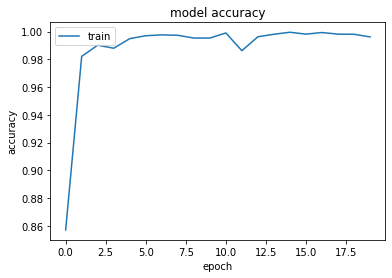

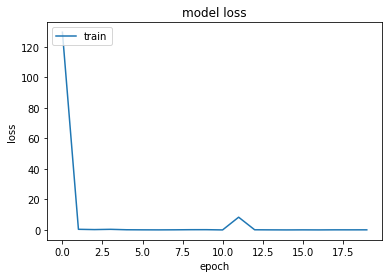

In [ ]:
model.evaluate(patient_test,label_test)
print(history3.history.keys())
# summarize history for accuracy
plt.plot(history3.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history3.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(patient_test,label_test)
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Torch models

In [ ]:
import torch
from torch import nn


class class_model(nn.Module):

    def __init__(self):
        super(class_model, self).__init__()  # 子类继承父类的初始化

        self.conv2d1 = nn.Conv2d(1, 32, 3)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2d2 = nn.Conv2d(32, 64, 3)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64 * 64009, 100)
        self.dropout = nn.Dropout(0.2)
        self.linear2 = nn.Linear(100, 5)
        self.softmax = nn.Softmax()



    def forward(self, x):
        output1 = self.conv2d1(x)
        output2 = self.relu(output1)
        output3 = self.maxpool1(output2)
        output4 = self.conv2d2(output3)
        output4_1 = output4.view(1, -1)
        output5 = self.flatten(output4_1)
        output6 = self.linear1(output5)
        output7 = self.dropout(output6)
        output8 = self.linear2(output7)
        output9 = self.softmax(output8)
        return output9


class stage_model(nn.Module):

    def __init__(self):
        super(stage_model, self).__init__()  # 子类继承父类的初始化

        self.conv2d1 = nn.Conv2d(1, 32, 3)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2d2 = nn.Conv2d(32, 64, 3)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64 * 64009, 100)
        self.dropout = nn.Dropout(0.2)
        self.linear2 = nn.Linear(100, 4)
        self.softmax = nn.Softmax()



    def forward(self, x):
        output1 = self.conv2d1(x)
        output2 = self.relu(output1)
        output3 = self.maxpool1(output2)
        output4 = self.conv2d2(output3)
        output4_1 = output4.view(1, -1)
        output5 = self.flatten(output4_1)
        output6 = self.linear1(output5)
        output7 = self.dropout(output6)
        output8 = self.linear2(output7)
        output9 = self.softmax(output8)
        return output9

Data Flattening for compatability

In [ ]:
nsamples, nx, ny = patient_train.shape
patient_train= patient_train.reshape((nsamples,nx*ny))
nsamples1, nx1, ny1 = patient_test.shape
patient_test= patient_test.reshape((nsamples1,nx1*ny1))
print(np.shape(patient_train))

# SVM Models

Different Kernels

In [ ]:
model = svm.SVC(kernel = 'sigmoid')
model.fit(patient_train, label_train)
pred = model.predict(patient_test)
print("Accuracy:",metrics.accuracy_score(label_test, pred))

In [ ]:
model = svm.SVC(kernel = 'rbf')
model.fit(patient_train, label_train)
pred = model.predict(patient_test)
print("Accuracy:",metrics.accuracy_score(label_test, pred))

Accuracy: 0.8572018159306645


In [ ]:
model = svm.SVC(kernel = 'gaussian')
model.fit(patient_train2, label_train)
pred = model.predict(patient_test2)
print("Accuracy:",metrics.accuracy_score(label_test, pred))

In [ ]:
model = svm.SVC(kernel = 'bessel')
model.fit(patient_train, label_train)
pred = model.predict(patient_test)
print("Accuracy:",metrics.accuracy_score(label_test, pred))

ValueError: ignored

Margin Changes to C value

In [ ]:
model = svm.SVC(kernel = 'linear')
model.fit(patient_train, label_train)
pred = model.predict(patient_test)
print("Accuracy:",metrics.accuracy_score(label_test, pred))

# RT Models

RT Model

In [ ]:
model=RandomForestClassifier(n_estimators=100)
model.fit(patient_train, label_train)
pred1 = model.predict(patient_test)
print("Accuracy:",metrics.accuracy_score(label_test, pred1))

NameError: ignored

RT optimization using search CV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42)
# Fit the random search model
rf_random.fit(patient_train, label_train)
rf_random.best_params_
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy

base_accuracy = evaluate(model, patient_test, label_test)
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, patient_test, label_test)
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))